# Aspect Identifying via Clustering for Classification

In [1]:
import preprocessor as p #https://pypi.org/project/tweet-preprocessor/
import numpy as np
import pandas as pd
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import string
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## A. Preprocessing and Cleaning the Data

In [2]:
df = pd.read_csv('data/Tweets.csv')
tweets = df.text

#### To start, we are going to review the initial set of negative reasons, the original aspect classification, as we move along towards defining our own clusters

In [3]:
df.negativereason.value_counts(dropna=False)

NaN                            5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

#### The below value shows that 45% of the dataset is listed as NaN or Can't Tell for the aspect or reason behind the tweet

In [4]:
(5462+1190)/14640

0.45437158469945355

#### Turn tweet to lowercase, remove all html or links, then clean up hashtags, mentions, and emojis

In [5]:
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = BeautifulSoup(tweet, 'html.parser').getText()
    tweet = p.clean(tweet)
    return tweet

In [6]:
clean_tweets = []
for tweet in tweets:
    clean_tweets.append(preprocess(tweet))

In [7]:
tweets = clean_tweets

## B. Tokenizing and Vectorizing the Terms in the Tweets for Clustering

#### Define stopwords and stemmer (how the words are trimmed and small ones removed)

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [9]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        #remove words that are 2 characters or less
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [10]:
def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        #remove words that are 2 characters or less
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens

#### Compare the list of stemmed vs tokenized to create the vocabulary we will use for the clustering

In [11]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in tweets:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'tweets', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [12]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

#### Only use words that appear 20% of the time, because most of language is repetitive 
<em>(https://www.strategiesinlanguagelearning.com/repetition-in-language-learning/)</em>

In [13]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.20,
                                   stop_words='english', max_features=1000,
                                   strip_accents='unicode', use_idf=True, 
                                   preprocessor=preprocess,
                                   tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets) #fit the vectorizer to tweets

C:\Code\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "con" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'v

Wall time: 12.8 s


In [14]:
terms = tfidf_vectorizer.get_feature_names()
#print(terms)
tfidf_vectorizer.fit(tweets)
%time text = tfidf_vectorizer.transform(tweets)
#print(text)

C:\Code\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 17.8 s


## C. Clustering the terms

### First pass, using inertia score and elbow curve to find optimal cluster amount

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


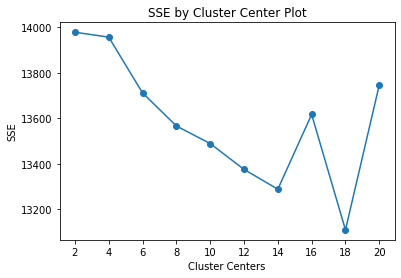

In [15]:
def find_optimal_amt_of_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_amt_of_clusters(text, 20)

In [16]:
cluster_amt = 8

In [17]:
num_clusters = cluster_amt

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 8.68 s


In [18]:
Tweets = {'tweet': tweets, 'cluster': clusters}

frame = pd.DataFrame(Tweets)
frame['Aspect'] = "Miscellaneous"

frame['cluster'].value_counts() #number of tweets per cluster (clusters from 0 to 9)


4    8850
2    1493
3     976
6     846
0     842
5     620
1     605
7     408
Name: cluster, dtype: int64

In [19]:
aspectsDF = pd.DataFrame(columns = ['Word', "Reason"])

### Now with the terms in clusters, we are going to manually review and assign them for classification

In [20]:
print("Top terms per cluster:")

#https://7esl.com/contractions-list/
#first pass throughs of model gave way to words that were most common but do not contribute to aspects, so they were added here to custom stop_words
contractions_and_common_words = [
    "n't","'s","'m","'ll","'d","'ve","'re","flying","flight","flightled","airline","fleek","fleet","did","does","flt"]
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(cluster_amt):
    print("Cluster %d words:" % i, end='')
    name = "Cluster %d words:" % i
    
    for ind in order_centroids[i, :20]:
        word = ' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        word = word.replace(" ", "")
        if word not in aspectsDF.values and word not in contractions_and_common_words:
            print(word, end=',')
            aspectsDF.loc[len(aspectsDF.index)] = [word, "Miscellaneous"]
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:
Cluster 0 words:cancelled,rebook,hold,tomorrow,help,hour,today,dfw,need,

Cluster 1 words:service,customer,worst,thanks,terrible,phone,poor,great,line,agent,

Cluster 2 words:why,bag,time,change,working,know,because,booking,waited,online,

Cluster 3 words:just,late,flightr,got,days,want,trying,delayed,sent,

Cluster 4 words:please,gate,seats,guys,like,check,making,love,

Cluster 5 words:plane,sit,boarding,left,new,passengers,issue,leaving,

Cluster 6 words:minutes,

Cluster 7 words:awesome,appreciate,follow,good,updates,very,safe,okay,yes,respond,



# D. Assigning the Aspects
<p> With the clustering analysis put together, we see words that correspond and have correlation together. Instead of assigning a cluster per tweet, we use the most commonly found and correlated words to create a dictionary of terms. This dictionary will then be used to assign Aspects to the tweets based on the words found. Because we saw similar words in certain clusters, we merged into the aspects listed below.</p>

In [21]:
aspect_assignments = {'Customer Service':['accomodate', 'contact', 'emailed', 'fix', 'staff', 'speak', 'talk', 
                                          'care', 'experience', 'rep', 'issue', 'thanks', 'hold', 'thank', 'appreciate', 
                                          'response', 'service', 'customer', 'phone', 'agent', 'email', 'speak', 'help', 
                                          'please', 'call', 'refund', 'need'],
                      'Ongoing Flight(s)':['travel', 'wifi', 'leaving', 'updates', 'weather', 'attendant', 'connecting', 
                                           'early', 'arrived', 'landed', 'gate', 'delay', 'delayed', 'late', 'status', 
                                           'schedule', 'cancelled', 'cancel', 'pilots', 'pilot', 'passengers', 'passenger', 
                                           'boarding'],
                      'Booking': ['sit', 'pass', 'credit', 'miles', 'hotel', 'app', 'fee', 'voucher', 'upgrade', 'class',
                                  'available', 'website', 'online', 'book', 'booking', 'seats', 'seat', 'boarding', 
                                  'rebook', 'confirmation', 'reschedule', 'ticket', 'reserved'],
                      'Luggage': ['bag', 'check', 'lost', 'baggage', 'bags', 'luggage', 'claim'],
                      'Wait Times': ['wait', 'waited', 'stuck', 'line', 'hour', 'hours', 'minutes', 'days', 'today', 
                                     'tomorrow', 'time', 'min', 'hrs']
                      }

def get_key(val):
    for key, value in aspect_assignments.items():
        for item in value:
            if (val == item):
                return key

In [22]:
def get_aspect_for_tweet(tweet):
    cs = 0
    of = 0
    bo = 0
    lu = 0
    wt = 0
    me = 0
    tweet_array = tweet.split(" ")
    for word in tweet_array:
        tof = False
        for value in aspect_assignments.values():
            if (word in value):
                tof = True
                aspect = get_key(word)
                if aspect == 'Customer Service':
                    cs += 1
                if aspect == 'Ongoing Flight(s)':
                    of += 1
                if aspect == 'Booking':
                    bo += 1
                if aspect == 'Luggage':
                    lu += 1
                if aspect == 'Wait Times':
                    wt += 1
                break

    assignments = {'cs': cs,'of': of,'bo': bo,'lu': lu,'me': me}
    test_value = max(assignments.values())
    test_key = 'me'
    if test_value > 0:
        for key, value in assignments.items():
            if test_value == value:
                test_key = key
                break
    aspects = {'cs': 'Customer Service', 'of': 'Ongoing Flight(s)', 'bo': 'Booking', 'lu': 'Luggage', 'me': "Miscellaneous"} 
    tweet_index = frame.index[frame['tweet'] == tweet].tolist()[0]
    frame.loc[tweet_index, 'Aspect'] = aspects[test_key]

In [23]:
for tweet in tweets:
    get_aspect_for_tweet(tweet)

## E. Comparison of Values to see if the clustering has defined more aspects

In [24]:
df['Aspect'] = frame['Aspect']

In [25]:
df.negativereason.value_counts(dropna=False)

NaN                            5462
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

#### Here is the original rate of missing data (45%)

In [26]:
(5462+1190)/14640

0.45437158469945355

In [27]:
df.Aspect.value_counts(dropna=False)

Miscellaneous        6027
Customer Service     4710
Ongoing Flight(s)    2251
Booking              1013
Luggage               639
Name: Aspect, dtype: int64

#### Here is our new rate of missing classified data (41%) showing that the aspect clustering improves the dataset to a small degree, but the manual labor involved may not provide as much benefit as intended.

In [28]:
6027/14640

0.41168032786885245

# Sentiment Analysis

The second classification task in this process is that of sentiment. Combined with the aspect of the tweet classified above, this yields aspect-based sentiment analysis to understand which airlines are receiving the most complaints against which facets of their customer service.

The baseline accuracy using a TF-IDF + Naive Bayes Classifier is: 70%.

<p> An additional 4 sentiment models were evaluated against the Airline Tweets dataset: </p>

- VADER - SentimentIntensityAnalyzer (nltk): 65%
        Precision: 0.898
        Recall: 0.504
        Accuracy: 0.653
        F1 Score: 0.646
- Textblob x NaiveBayesAnalyzer (nltk): 69%
        Precision: 0.775
        Recall: 0.716
        Accuracy: 0.692
        F1 Score: 0.744
- Hugging Face (BERT): 79%
        Precision: 0.939
        Recall: 0.711
        Accuracy: 0.790
        F1 Score: 0.809
- Fine-tuned Hugging Face (BERT): 89% on the test subset.
        With another airline tweets dataset:
        Precision: 0.853
        Recall: 0.738
        Accuracy: 0.791
        F1 Score: 0.791

Hugging Face with fine tuning was chosen as the final model. 

## Model 1: VADER - SentimentIntensityAnalyzer (nltk)

The first model is an algorithm from the nltk package:

#### How does VADER work? (https://medium.com/ro-data-team-blog/nlp-how-does-nltk-vader-calculate-sentiment-6c32d0f5046b)


Valence Aware Dictionary for sEntiment Reasoning, or Vader, is a NLP algorithm that blended a sentiment lexicon approach as well as grammatical rules and syntactical conventions for expressing sentiment polarity and intensity. Vader is an open-sourced package within the Natural Language Toolkit (NLTK) and here are the source code and the original publication if you are interested to check them out.

The lexicon approach means that this algorithm constructed a dictionary that contains a comprehensive list of sentiment features. This lexical dictionary does not only contain words, but also phrases (such as “bad ass” and “the bomb”), emoticons (such as “:-)”) and sentiment-laden acronyms (such as “ROFL” and “WTF”). All the lexical features were rated for the polarity and intensity on a scale from “-4: Extremely Negative” to “+4 Extremely Positive” by 10 independent human raters. The average score is then used as the sentiment indicator for each lexical feature in the dictionary.

The main drawback with the rule-based approach for sentiment analysis is that the method only cares about individual words and completely ignores the context in which it is used. 

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')

from nltk.stem.porter import *
stemmer = PorterStemmer()
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

from textblob import TextBlob
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutikorada/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutikorada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Format data from aspect analysis

In [49]:
tweets = pd.read_csv('Tweets.csv')
frame = frame.reset_index()
tweets = tweets.join(frame)
tweets = tweets.rename(columns={"tweet":"Tweet","text":"Tweet"})
tweets.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,Tweet,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


### Calculate sentiment and compare to given label

In [50]:
# assign sentiment scores
scores = []
for tweet in tweets['Tweet']:
    score = sia.polarity_scores(tweet)
    scores.append(score['compound'])
tweets['sentiment_scores'] = scores
tweets['sentiment_derived'] = ["positive" if w >0 else "negative" if w < 0 else "neutral" for w in tweets['sentiment_scores']]

In [51]:
# percent match between assigned and derived sentiment
tweets['match'] = (tweets['sentiment_derived']==tweets['airline_sentiment']).astype(int)
tweets[['airline_sentiment','sentiment_derived','match']]
tweets['match'].mean()

0.5466530054644809

About 50% of the derived sentiment scores match the original scores. Most of the errors are negative or neutral tweets that are misclassified as neutral or positive. Assess additional sentiment analyzers to improve accuracy:

In [52]:
# crosstab of assigned vs derived sentiment
pd.crosstab(tweets.airline_sentiment, tweets.sentiment_derived)

sentiment_derived,negative,neutral,positive
airline_sentiment,,,
negative,4629,1752,2797
neutral,433,1309,1357
positive,93,205,2065


Relabel tweets from multi-class to binary for ease of interpretation.

In [128]:
tweets['airline_sentiment_dum'] = np.where(
        tweets['airline_sentiment']=='negative', 1, np.where(
        tweets['airline_sentiment']=='neutral', 0, np.where(
        tweets['airline_sentiment']=='positive',0, 0)))

tweets['sentiment_derived_dum'] = np.where(
        tweets['sentiment_derived']=='negative', 1, np.where(
        tweets['sentiment_derived']=='neutral', 0, np.where(
        tweets['sentiment_derived']=='positive',0, 0)))

### Calculate model performance metrics

The model has an accuracy rate of 65%.

In [60]:
conf_matrix = confusion_matrix(y_true=tweets.airline_sentiment_dum, y_pred=tweets.sentiment_derived_dum)
print('Precision: %.3f' % precision_score(tweets.airline_sentiment_dum, tweets.sentiment_derived_dum))
print('Recall: %.3f' % recall_score(tweets.airline_sentiment_dum, tweets.sentiment_derived_dum))
print('Accuracy: %.3f' % accuracy_score(tweets.airline_sentiment_dum, tweets.sentiment_derived_dum))
print('F1 Score: %.3f' % f1_score(tweets.airline_sentiment_dum, tweets.sentiment_derived_dum))

Precision: 0.898
Recall: 0.504
Accuracy: 0.653
F1 Score: 0.646


## Model 2: TextBlob and NaiveBayesClassifier

This model generates a sentiment classification from a rank vote of the least negative of two individual classifiers, nltk's TextBlob and NaiveBayesClassifier. I want to see whether this method resolves some of the misclassification we see in positive vs. neutral and negative vs. neutral in the previous model. 

#### How does TextBlob work? (https://neptune.ai/blog/sentiment-analysis-python-textblob-vs-vader-vs-flair)

It is a simple python library that offers API access to different NLP tasks such as sentiment analysis, spelling correction, etc.

Textblob sentiment analyzer returns two properties for a given input sentence: 

Polarity is a float that lies between [-1,1], -1 indicates negative sentiment and +1 indicates positive sentiments. 
Subjectivity is also a float which lies in the range of [0,1]. Subjective sentences generally refer to personal opinion, emotion, or judgment. 

Textblob will ignore the words that it doesn’t know, it will consider words and phrases that it can assign polarity to and averages to get the final score.

### Calculate sentiment and compare to given label

In [61]:
blobber = Blobber(analyzer=NaiveBayesAnalyzer())

scores = []
for tweet in tweets['Tweet']:
    score = TextBlob(tweet)
    scores.append(score.sentiment[0])
tweets['textblob_scores'] = scores
tweets['textblob_derived'] = ["positive" if w >0 else "negative" if w < 0 else "neutral" for w in tweets['textblob_scores']]

In [62]:
pd.crosstab(tweets.sentiment_derived, tweets.textblob_derived)

textblob_derived,negative,neutral,positive
sentiment_derived,,,
negative,2480,1646,1029
neutral,461,2133,672
positive,728,1715,3776


### Rank vote to generate predicted label from the 'most negative' of both classifications

In [63]:
def combined_sentiment(tweets):
    if (tweets['textblob_derived'] == 'negative') or (tweets['sentiment_derived'] == 'negative'):
        return 'negative'
    if (tweets['textblob_derived'] == 'neutral') and (tweets['sentiment_derived'] == 'positive'):
        return 'neutral'
    if (tweets['textblob_derived'] == 'positive') and (tweets['sentiment_derived'] == 'neutral'):
        return 'neutral'
    if (tweets['textblob_derived'] == 'neutral') and (tweets['sentiment_derived'] == 'neutral'):
        return 'negative'
    if (tweets['textblob_derived'] == 'positive') and (tweets['sentiment_derived'] == 'positive'):
        return 'positive'
    else:
        return '0'

In [64]:
tweets['final_derived'] = tweets.apply(combined_sentiment, axis=1)

In [65]:
pd.crosstab(tweets.final_derived, tweets.airline_sentiment)

airline_sentiment,negative,neutral,positive
final_derived,,,
negative,6572,1613,292
neutral,1229,788,370
positive,1377,698,1701


In [66]:
# percent match between assigned and derived sentiment
tweets['match'] = (tweets['final_derived']==tweets['airline_sentiment']).astype(int)
tweets[['airline_sentiment','final_derived','match']]
tweets['match'].mean()

0.6189207650273224

In [67]:
tweets['final_derived_dum'] = np.where(
        tweets['final_derived']=='negative', 1, np.where(
        tweets['final_derived']=='neutral', 0, np.where(
        tweets['final_derived']=='positive',0, 0)))

In [68]:
conf_matrix = confusion_matrix(y_true=tweets.airline_sentiment_dum, y_pred=tweets.final_derived_dum)
print('Precision: %.3f' % precision_score(tweets.airline_sentiment_dum, tweets.final_derived_dum))
print('Recall: %.3f' % recall_score(tweets.airline_sentiment_dum, tweets.final_derived_dum))
print('Accuracy: %.3f' % accuracy_score(tweets.airline_sentiment_dum, tweets.final_derived_dum))
print('F1 Score: %.3f' % f1_score(tweets.airline_sentiment_dum, tweets.final_derived_dum))

Precision: 0.775
Recall: 0.716
Accuracy: 0.692
F1 Score: 0.744


Accuracy has improved moderately with a combination of sentiment classifiers. 

In [70]:
# % negative sentiment by cluster using derived sentiment
tweets['negative'] = np.where(tweets['final_derived']== 'negative', True, False)
tweets.groupby('cluster')['negative'].mean()

In [ ]:
# % negative sentiment by cluster using sentiment from original dataset
tweets['negative_orig'] = np.where(tweets['airline_sentiment']== 'negative', True, False)
tweets.groupby('cluster')['negative_orig'].mean()

Initial results indicate that Cluster 3 (key words: b'delayed', b'flight', b'hour', b'missed', b'connecting', b'plane') is the most negative.

In [130]:
tweets['Tweet'][3]

## Model 3: Hugging Face

The Twitter-roBERTa-base model is a pre-trained BERT model which has been trained on 50mm tweets.

Code source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

#### How do the Hugging Face Transformers work? (https://www.section.io/engineering-education/hugging-face/)

Intending to democratize NLP and make models accessible to all, they have created an entire library providing various resources. Some of these resources include datasets, tokenizers, and transformers to perform NLP related tasks ranging from chatbots to question and answering systems.

The Hugging Face Transformers library provides thousands of models that enable a developer to perform various NLP tasks. A few include text classification, information retrieval, information extraction, abstractive and extractive summarization, name-entity recognition, natural language inference, text translation, text generation, question answering, image captioning, etc. to name a few.

The library provides APIs that download the pre-trained models. Once the pre-trained models are downloaded, the high-level research on the domains of NLU and NLG can be performed easily. Transformers library is bypassing the initial work of setting up the environment and architecture.

HuggingFace transformers support the two popular deep learning libraries, TensorFlow and PyTorch.

In [71]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

### Preprocess text

In [72]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []

    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [ ]:
rm -r ./cardiffnlp

### Initialize the model

In [73]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [74]:
# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [75]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)

('cardiffnlp/twitter-roberta-base-sentiment/tokenizer_config.json',
 'cardiffnlp/twitter-roberta-base-sentiment/special_tokens_map.json',
 'cardiffnlp/twitter-roberta-base-sentiment/vocab.json',
 'cardiffnlp/twitter-roberta-base-sentiment/merges.txt',
 'cardiffnlp/twitter-roberta-base-sentiment/added_tokens.json',
 'cardiffnlp/twitter-roberta-base-sentiment/tokenizer.json')

### Calculate sentiment and compare to given label

In [76]:
final_scores = []

for tweet in tweets['Tweet']:
    
    text = tweet
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    # # TF
    # model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
    # model.save_pretrained(MODEL)

    # text = "Good night 😊"
    # encoded_input = tokenizer(text, return_tensors='tf')
    # output = model(encoded_input)
    # scores = output[0][0].numpy()
    # scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        #print(f"{i+1}) {l} {np.round(float(s), 4)}")
        
    final_score = labels[ranking[0]]
    final_scores.append(final_score)

In [77]:
tweets['hugging_face'] = final_scores

In [78]:
pd.crosstab(tweets.hugging_face, tweets.airline_sentiment)

airline_sentiment,negative,neutral,positive
hugging_face,,,
negative,6526,383,38
neutral,2162,2144,193
positive,490,572,2132


In [79]:
# percent match between assigned and derived sentiment
tweets['match_hf'] = (tweets['hugging_face']==tweets['airline_sentiment']).astype(int)
tweets[['airline_sentiment','hugging_face','match_hf']]
tweets['match_hf'].mean()

0.7378415300546448

In [80]:
# Relabel tweets to two classes: 1 (negative) and 0 (neutral, positive).
tweets['hugging_face_dum'] = np.where(
        tweets['hugging_face']=='negative', 1, np.where(
        tweets['hugging_face']=='neutral', 0, np.where(
        tweets['hugging_face']=='positive',0, 0)))

In [81]:
conf_matrix = confusion_matrix(y_true=tweets.airline_sentiment_dum, y_pred=tweets.hugging_face_dum)
print('Precision: %.3f' % precision_score(tweets.airline_sentiment_dum, tweets.hugging_face_dum))
print('Recall: %.3f' % recall_score(tweets.airline_sentiment_dum, tweets.hugging_face_dum))
print('Accuracy: %.3f' % accuracy_score(tweets.airline_sentiment_dum, tweets.hugging_face_dum))
print('F1 Score: %.3f' % f1_score(tweets.airline_sentiment_dum, tweets.hugging_face_dum))

Precision: 0.939
Recall: 0.711
Accuracy: 0.790
F1 Score: 0.809


Implementing the Twitter-roBERTa-base model for Sentiment Analysis improves the model accuracy by 10%+ to 72%.

## Model 4: Fine-tuning BERT

Does fine-tuning the Hugging Face pretrained model improve accuracy against a baseline, as measured by TD-IDF and a Naive Bayes classifier? The process below shows that a model performs almost 20 percentage points better than the baseline, beating out the other models and suggesting a production-level model may be recommended.

Source tutorial: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

### Load libraries

In [85]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

%matplotlib inline

### Load the data

In [86]:
tweets = pd.read_csv('data/Tweets.csv')
tweets.columns.tolist()
# Rename columns
tweets = tweets.rename(columns={"text":"tweet"})

Double check that no tweets are missing labels.

In [87]:
tweets.airline_sentiment.value_counts(dropna=False)

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Relabel tweets to two classes: 1 (negative) and 0 (neutral, positive).

In [88]:
tweets['label'] = np.where(
    tweets['airline_sentiment']=='negative', 1, np.where(
    tweets['airline_sentiment']=='neutral', 0, np.where(
    tweets['airline_sentiment']=='positive',0, 0)))

In [89]:
# Load data and set labels
data = tweets

# Keep required columns
data = data[['tweet','label']]

# Display 5 random samples
data.sample(5)

,tweet,label
7070,No. RT @JetBlue Our fleet's on fleek.,0
10495,@USAirways Ok Thanks,0
8463,@JetBlue it says it is now 9:58 you owe me,1
5525,@SouthwestAir #promotion fly 3 roundtrip #flig...,0
3115,"@united i got it at the gate, thanks for check...",0


We will randomly split the entire training data into two sets: a train set with 90% of the data and a validation set with 10% of the data. We will perform hyperparameter tuning using cross-validation on the train set and use the validation set to compare models.

In [90]:
from sklearn.model_selection import train_test_split

X = data.tweet.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

### Load Test Data

In [99]:
# Load test data
test_data = pd.read_csv('data/test_data.csv')

# Keep important columns
test_data = test_data[['Tweet', 'Sentiment']]

# Relabel tweets to two classes: 1 (negative) and 0 (neutral, positive).
test_data['label'] = np.where(
    test_data['Sentiment']=='negative', 1, np.where(
    test_data['Sentiment']=='neutral', 0, np.where(
    test_data['Sentiment']=='positive',0, 0)))

# Relabel tweet variable
test_data = test_data.rename(columns={"Tweet":"tweet"})

# Display 5 samples from the test data
test_data.sample(5)

,tweet,Sentiment,label
1773,@johncardillo @JetBlue Provided his arm/beard ...,neutral,0
3997,@qatarairways @AmericanAir @JetBlue Sorry to s...,negative,1
2133,Yay! Delays! Delay! Delays! And more delays! S...,positive,0
585,@UICProfWatch @Delta @deltacares I feel you! I...,negative,1
2430,@SouthwestAir Nowhere with you https://t.co/MU...,neutral,0


### Baseline: TF-IDF + Naive Bayes Classifier

In this baseline approach, first we will use TF-IDF to vectorize our text data. Then we will use the Naive Bayes model as our classifier.

Why Naive Bayes? I have experiemented different machine learning algorithms including Random Forest, Support Vectors Machine, XGBoost and observed that Naive Bayes yields the best performance. In Scikit-learn's guide to choose the right estimator, it is also suggested that Naive Bayes should be used for text data. I also tried using SVD to reduce dimensionality; however, it did not yield a better performance.

#### Data preparation

#### Preprocessing

In the bag-of-words model, a text is represented as the bag of its words, disregarding grammar and word order. Therefore, we will want to remove stop words, punctuations and characters that don't contribute much to the sentence's meaning.

In [92]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutikorada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### TF-IDF Vectorizer

In information retrieval, TF-IDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. We will use TF-IDF to vectorize our text data before feeding them to machine learning algorithms.

In [93]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

CPU times: user 48.7 s, sys: 10.9 s, total: 59.7 s
Wall time: 1min 1s


### Train Naive Bayes Classifier
#### Hyperparameter Tuning
We will use cross-validation and AUC score to tune hyperparameters of our model. The function get_auc_CV will return the average AUC score from cross-validation.

In [20]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

The MultinominalNB class only have one hypterparameter - alpha. The code below will help us find the alpha value that gives us the highest CV AUC score.

In [30]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

### Evaluation on Validation Set
To evaluate the performance of our model, we will calculate the accuracy rate and the AUC score of our model on the validation set.

In [11]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

By combining TF-IDF and the Naive Bayes algorithm, we achieve the accuracy rate of 71.65% on the validation set. This value is the baseline performance and will be used to evaluate the performance of our fine-tune BERT model.

AUC: 0.9039
Accuracy: 71.65%


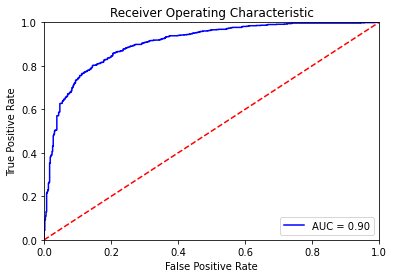

In [12]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

- AUC: 0.9039
- Accuracy: 71.65%

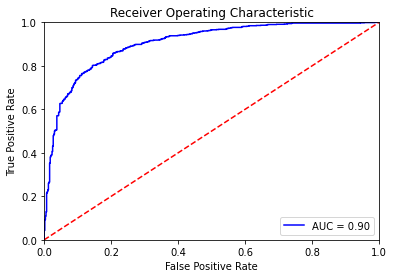

### Fine-tuning the model
#### Install the Hugging Face Library
The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [13]:
#!pip install transformers

### Tokenization and Input Formatting
Before tokenizing our text, we will perform some slight processing on our text including removing entity mentions (eg. @united) and some special character. The level of processing here is much less than in previous approachs because BERT was trained with the entire sentences.

In [14]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [15]:
# Print sentence 3
print('Original: ', X[3])
print('Processed: ', text_preprocessing(X[3]))

Original:  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Processed:  it's really aggressive to blast obnoxious "entertainment" in your guests' faces & they have little recourse


### BERT Tokenizer¶
In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [101]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [102]:
# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in data.tweet]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  67


In [103]:
# Specify `MAX_LEN`
MAX_LEN = 67

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  @VirginAmerica What @dhepburn said.
Token IDs:  [101, 2056, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/Users/shrutikorada/opt/anaconda3/envs/fsan815/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2132: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### Create PyTorch DataLoader
We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [104]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Train Our Model
### Create BertClassifier
BERT-base consists of 12 transformer layers, each transformer layer takes in a list of token embeddings, and produces the same number of embeddings with the same hidden size (or dimensions) on the output. The output of the final transformer layer of the [CLS] token is used as the features of the sequence to feed a classifier.

The transformers library has the BertForSequenceClassification class which is designed for classification tasks. However, we will create a new class so we can specify our own choice of classifiers.

Below we will create a BertClassifier class with a BERT model to extract the last hidden layer of the [CLS] token and a single-hidden-layer feed-forward neural network as our classifier.

In [95]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 279 µs, sys: 301 µs, total: 580 µs
Wall time: 624 µs


### Optimizer & Learning Rate Scheduler
To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

Batch size: 16 or 32
Learning rate (Adam): 5e-5, 3e-5 or 2e-5
Number of epochs: 2, 3, 4
Huggingface provided the run_glue.py script, an examples of implementing the transformers library. In the script, the AdamW optimizer is used.

In [105]:
# Set device
device = torch.device("cpu")

In [106]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### Training Loop
We will train our Bert Classifier for 1 epoch. In this epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

#### Training:

Unpack our data from the dataloader and load the data onto the GPU
Zero out gradients calculated in the previous pass
Perform a forward pass to compute logits and loss
Perform a backward pass to compute gradients (loss.backward())
Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
Update the model's parameters (optimizer.step())
Update the learning rate (scheduler.step())

#### Evaluation:

Unpack our data and load onto the GPU
Forward pass
Compute loss and accuracy rate over the validation set
The script below is commented with the details of our training and evaluation loop.

In [107]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [34]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=1)
train(bert_classifier, train_dataloader, val_dataloader, epochs=1, evaluation=True)

### Evaluation on Validation Set
The prediction step is similar to the evaluation step that we did in the training loop, but simpler. We will perform a forward pass to compute logits and apply softmax to calculate probabilities.

In [133]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [134]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

NameError: name 'evaluate_roc' is not defined

In [ ]:
conf_matrix = confusion_matrix(y_true=test_data.label, y_pred=test_data.prediction)
print('Precision: %.3f' % precision_score(test_data.label, test_data.prediction))
print('Recall: %.3f' % recall_score(test_data.label, test_data.prediction))
print('Accuracy: %.3f' % accuracy_score(test_data.label, test_data.prediction))
print('F1 Score: %.3f' % f1_score(test_data.label, test_data.prediction))

- AUC: 0.9517
- Accuracy: 89.21%

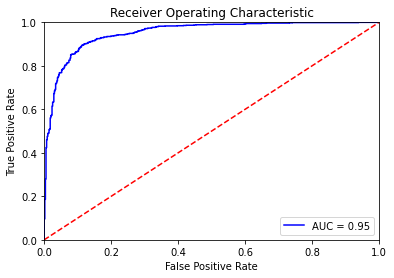

The Bert Classifer achieves 0.95 AUC score and 89.21% accuracy rate on the validation set. This result is 18 points better than the baseline method.

### Train Our Model on the Entire Training Data

In [28]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, full_train_dataloader, epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.564158   |     -      |     -     |  670.24  
   1    |   40    |   0.429748   |     -      |     -     |  621.51  
   1    |   60    |   0.357444   |     -      |     -     |  601.07  
   1    |   80    |   0.359545   |     -      |     -     |  618.41  
   1    |   100   |   0.346490   |     -      |     -     |  598.78  
   1    |   120   |   0.394200   |     -      |     -     |  584.63  
   1    |   140   |   0.301688   |     -      |     -     |  617.72  
   1    |   160   |   0.330467   |     -      |     -     |  617.81  
   1    |   180   |   0.300982   |     -      |     -     |  633.32  
   1    |   200   |   0.319487   |     -      |     -     |  594.82  
   1    |   220   |   0.338539   |     -      |     -     |  603.86  
   1    |   240   |   0.290582   |     -      |     -     |  605.50  


In [29]:
import joblib
# save the model as a pickle file
joblib.dump(bert_classifier, "bert_classifier.pickle")
# Load the model from a pickle file
#kmeans_from_file = joblib.load("kmeans.pickle")
#kmeans_from_file

['bert_classifier.pickle']

In [98]:
import joblib
# Load the model from a pickle file
bert_classifier = joblib.load("bert_classifier.pickle")
bert_classifier

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

### Predictions on Test Set¶
#### Data Preparation
Let's revisit our test set.

In [108]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.tweet)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### Predictions
There are 2208 non-negative tweets in our test set. Therefore, we will keep adjusting the decision threshold until we have about 2208 non-negative tweets.

The threshold we will use is 0.91, meaning that tweets with a predicted probability greater than 91.0% will be predicted positive. This value is very high compared to the default 0.5 threshold.

After manually examining the test set, I find that the sentiment classification task here is even difficult for human. Therefore, a high threshold will give us safe predictions.

In [124]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.91
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  2208


Now we will measure the accuracy of the BERT Classifer on the test set.

In [131]:
test_data['prediction'] = preds
test_data

,tweet,Sentiment,label,prediction
0,"And @Delta, get your SH*T together…as a large ...",negative,1,1
1,"@Delta I don't fly, and I SURE don't fly weari...",negative,1,0
2,@TravelwithGuy_ @Delta Thank you! I had an abs...,positive,0,0
3,@nvrcallme @Delta No vaccine has an efficacy r...,positive,0,0
4,@nvrcallme @Delta The vaccine is not experimen...,positive,0,0
...,...,...,...,...
4756,@paborman @FAANews @AmericanAir American Airli...,neutral,0,0
4757,@greenaligator1 @michaelmalice @AmericanAir So...,negative,1,1
4758,Could someone enlighten me as to why @Clear is...,negative,1,1
4759,"""Within half a year, American Airlines has not...",neutral,0,1


In [132]:
conf_matrix = confusion_matrix(y_true=test_data.label, y_pred=test_data.prediction)
print('Precision: %.3f' % precision_score(test_data.label, test_data.prediction))
print('Recall: %.3f' % recall_score(test_data.label, test_data.prediction))
print('Accuracy: %.3f' % accuracy_score(test_data.label, test_data.prediction))
print('F1 Score: %.3f' % f1_score(test_data.label, test_data.prediction))

Precision: 0.853
Recall: 0.738
Accuracy: 0.791
F1 Score: 0.791


## Conclusion
By adding a simple one-hidden-layer neural network classifier on top of BERT and fine-tuning BERT, we can achieve near state-of-the-art performance, which is 10 points better than the baseline method although we only have 3k data points.

In addition, although BERT is very large, complicated, and have millions of parameters, we only need to fine-tune it in only 2 epochs. That result can be achieved because BERT was trained on the huge amount and already encode a lot of information about our language. An impresive performance achieved in a short amount of time, with a small amount of data has shown why BERT is one of the most powerful NLP models available at the moment.